In [33]:
import pandas as pd

pokemon = pd.read_csv('./pokedex/pokemon.csv').sort_values(by=['number'])
pokemon

,generation,number,name,type1,type2,height,weight,catch_rate,egg_group1,egg_group2,has_gender,male,hp,attack,defense,sp_atk,sp_def,speed,total,is_legendary
0,1,1,Bulbasaur,Grass,Poison,0.7,6.9,45,Grass,Monster,True,87.5,45,49,49,65,65,45,318,False
20,1,2,Ivysaur,Grass,Poison,1.0,13.0,45,Grass,Monster,True,87.5,60,62,63,80,80,60,405,False
22,1,3,Venusaur,Grass,Poison,2.0,100.0,45,Grass,Monster,True,87.5,80,82,83,100,100,80,525,False
21,1,4,Charmander,Fire,NaN,0.6,8.5,45,Dragon,Monster,True,87.5,39,52,43,60,50,65,309,False
19,1,5,Charmeleon,Fire,NaN,1.1,19.0,45,Dragon,Monster,True,87.5,58,64,58,80,65,80,405,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,8,894,Regieleki,Electric,NaN,1.2,145.0,3,NaN,NaN,False,NaN,80,100,50,100,50,200,580,True
167,8,895,Regidrago,Dragon,NaN,2.1,200.0,3,NaN,NaN,False,NaN,200,100,50,100,50,80,580,True
166,8,896,Glastrier,Ice,NaN,2.2,800.0,3,NaN,NaN,False,NaN,100,145,130,65,110,30,580,True
169,8,897,Spectrier,Ghost,NaN,2.0,44.5,3,NaN,NaN,False,NaN,100,65,60,145,80,130,580,True


In [15]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898 entries, 0 to 168
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   generation    898 non-null    int64  
 1   number        898 non-null    int64  
 2   name          898 non-null    object 
 3   type1         898 non-null    object 
 4   type2         444 non-null    object 
 5   height        898 non-null    float64
 6   weight        898 non-null    float64
 7   catch_rate    898 non-null    int64  
 8   egg_group1    782 non-null    object 
 9   egg_group2    256 non-null    object 
 10  has_gender    898 non-null    bool   
 11  male          776 non-null    float64
 12  hp            898 non-null    int64  
 13  attack        898 non-null    int64  
 14  defense       898 non-null    int64  
 15  sp_atk        898 non-null    int64  
 16  sp_def        898 non-null    int64  
 17  speed         898 non-null    int64  
 18  total         898 non-null    

In [16]:
types = set.union(set(pokemon['type1'].value_counts().keys()), set(pokemon['type2'].value_counts().keys()))
egg_groups = set.union(set(pokemon['egg_group1'].value_counts().keys()), set(pokemon['egg_group2'].value_counts().keys()))
new_types = {k: v+1 for v, k in enumerate(types)}
new_egg_groups = {k: v+1 for v, k in enumerate(egg_groups)}
tf = { True: 1, False: 0}

data = pokemon.drop(columns=['number', 'name']) \
    .fillna(value=0) \
    .replace({"type1": new_types, "type2": new_types}) \
    .replace({"egg_group1": new_egg_groups, "egg_group2": new_egg_groups}) \
    .replace({"has_gender": tf, "is_legendary": tf})
data

,generation,type1,type2,height,weight,catch_rate,egg_group1,egg_group2,has_gender,male,hp,attack,defense,sp_atk,sp_def,speed,total,is_legendary
0,1,5,8,0.7,6.9,45,4,2,1,87.5,45,49,49,65,65,45,318,0
20,1,5,8,1.0,13.0,45,4,2,1,87.5,60,62,63,80,80,60,405,0
22,1,5,8,2.0,100.0,45,4,2,1,87.5,80,82,83,100,100,80,525,0
21,1,14,0,0.6,8.5,45,5,2,1,87.5,39,52,43,60,50,65,309,0
19,1,14,0,1.1,19.0,45,5,2,1,87.5,58,64,58,80,65,80,405,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,8,6,0,1.2,145.0,3,0,0,0,0.0,80,100,50,100,50,200,580,1
167,8,7,0,2.1,200.0,3,0,0,0,0.0,200,100,50,100,50,80,580,1
166,8,2,0,2.2,800.0,3,0,0,0,0.0,100,145,130,65,110,30,580,1
169,8,17,0,2.0,44.5,3,0,0,0,0.0,100,65,60,145,80,130,580,1


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898 entries, 0 to 168
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   generation    898 non-null    int64  
 1   type1         898 non-null    int64  
 2   type2         898 non-null    int64  
 3   height        898 non-null    float64
 4   weight        898 non-null    float64
 5   catch_rate    898 non-null    int64  
 6   egg_group1    898 non-null    int64  
 7   egg_group2    898 non-null    int64  
 8   has_gender    898 non-null    int64  
 9   male          898 non-null    float64
 10  hp            898 non-null    int64  
 11  attack        898 non-null    int64  
 12  defense       898 non-null    int64  
 13  sp_atk        898 non-null    int64  
 14  sp_def        898 non-null    int64  
 15  speed         898 non-null    int64  
 16  total         898 non-null    int64  
 17  is_legendary  898 non-null    int64  
dtypes: float64(3), int64(15)
memor

In [18]:
data['is_legendary'].value_counts()

0    806
1     92
Name: is_legendary, dtype: int64

In [19]:
# from sklearn.feature_selection import RFECV
# from sklearn.svm import SVR

# X = data
# y = data.is_legendary

# estimator = SVR(kernel="linear")
# selector = RFECV(estimator, step=1, cv=5)
# selector = selector.fit(X, y)
# print(selector.support_)
# print(selector.ranking_)


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = data.drop(columns=['is_legendary'])
y = data.is_legendary

# 75% for training and 25% for model testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(lr.score(X_train, y_train))

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

0.9985141158989599
Accuracy: 0.9688888888888889
Precision: 0.76
Recall: 0.95


In [20]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from pandas import DataFrame

# scaler = MinMaxScaler()
# transformed = DataFrame((scaler.fit_transform(data)))

# transformed

# X = scaler.transform(data)
# y = data.is_legendary
# # 75% for training and 25% for model testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(max_iter=1000)
# lr.fit(X_train,y_train)
# y_pred = lr.predict(X_test)
# print(lr.score(X_train, y_train))

# from sklearn import metrics
# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print(cnf_matrix)

# print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# print("Precision:", metrics.precision_score(y_test, y_pred))
# print("Recall:", metrics.recall_score(y_test, y_pred))

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# ROC Curve
# y_pred_proba = lr.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

# cross-validation
# from sklearn.model_selection import cross_validate
# print(cross_validate(lr, X, y, cv=10, scoring="accuracy"))


# f1 score

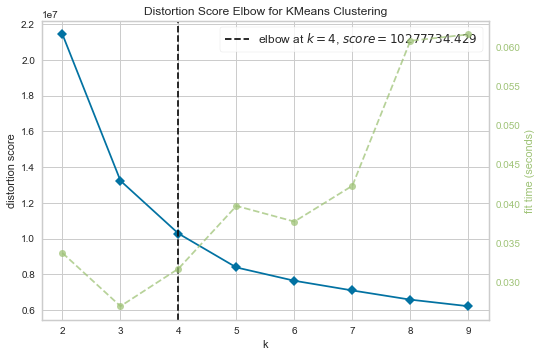

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler

X = data

model = KMeans(max_iter=1000, random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion')
# scaler = MinMaxScaler()
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
visualizer.fit(X)
visualizer.poof()

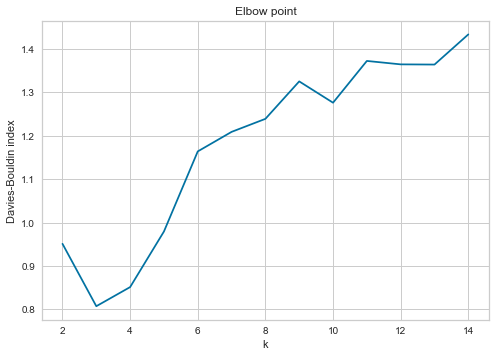

[0.951260139285163,
 0.8075262362860528,
 0.8515907459168003,
 0.9796719568359192,
 1.1641703073191183,
 1.20917261264487,
 1.2391692465012372,
 1.3254626685583826,
 1.276365159814144,
 1.3725804031199262,
 1.364694587631312,
 1.3642549640802208,
 1.433704808290887]

In [22]:
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

X = data
K = range(2, 15)
results = []

for k in K:
    km = KMeans(init="k-means++", n_clusters=k, random_state=42).fit(X)
    results.append(davies_bouldin_score(X, km.labels_))

plt.plot(K, results, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin index')
plt.title('Elbow point')
plt.show()    
results    

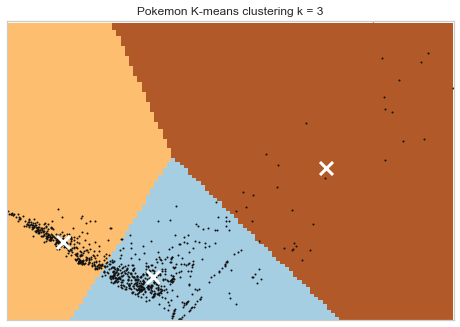

In [23]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

k = 3
kmeans = KMeans(init="k-means++", n_clusters=k)
reduced_data = PCA(n_components=2).fit_transform(data)
# reduced_data = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(pokemon[feature_cols])
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 10  # point in the mesh [x_min, x_max]x[y_min, y_max].

# # Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# # Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=4)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(f"Pokemon K-means clustering k = {k}")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()